## What I do

1. 实现计算欧式距离、闵可夫斯基距离和马氏距离的函数
2. 分别采用上述距离作为度量，实现了K-means聚类算法
3. 基于Sklearn和肘部法则对K-means算法进行验证性实验

## 实验介绍

### 1.实验内容

* 通过对给定数据进行聚类分析来了解K-means算法。

### 2.实验目标

* 通过本实验掌握K-means聚类算法

### 3.实验知识点

* K-means算法原理
* K-means算法流程
* K-means算法应用

### 4.实验环境

> 本地环境
* python 3.8.4
* numpy 1.22.4
* matplotlib 3.5.2

## 实验准备

点击屏幕右上方的下载实验数据模块，选择下载KmeansData.txt到指定目录下，然后再依次选择点击上方的File->Open->Upload,上传刚才下载的数据集

## 数据介绍

本数据是随机生成的符合高斯分布的二维样本点

## [K-means] 实验流程

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

## 1. 数据的读取与处理

In [2]:
def loadDataSet(fileName):
    """
    函数说明:加载数据集
    parameters:
        fileName - 文件名  
    return：
        DataMat - 数据集，DataFrame数据格式
    """
    data = pd.read_table(fileName,header=None)
    data = data.values#.tolist()
    
    return data

## 2. 样本点间的距离计算

### 2.1 欧氏距离
$$
dist = \sqrt{(\sum_{k=1}^n (p_k-q_k)^2)}
$$

In [3]:
def distEclud(vecA, vecB, **kwargs):
    """
    函数说明:利用欧式距离来计算每个样本点之间的距离
    parameters:
        vecA - A样本的特征向量（本数据中指它的二维坐标值）
        vecB - B样本的特征向量（本数据中指它的二维坐标值）  
    return：
        Dist - 样本点间的欧式距离
    """ 
    
    
    # 基于Numpy利用广播机制可以提高运算效率——Andrew Ng
    
    diff = np.array(np.array(vecA) - np.array(vecB))
    Dist = np.sqrt(np.sum(diff*diff))
    """
    # 自己实现
    Dist = 0
    acc = 0
    for i in range(size(vecA)):
        acc = acc + (vecA[i] - vecB[i])**2
    Dist = acc**0.5
    """

    return Dist

### 2.2 闵可夫斯基距离
$$
dist = (\sum_{k=1}^n|p_k-q_k|^r)^{\frac{1}{r}}
$$

> r=1时为Hamming Distance，r=2时为Euclidean Distance

In [4]:
# 基于Numpy实现
def distMink(vecA, vecB, **kwargs):
    """
    函数说明:利用闵可夫斯基距离来计算每个样本点之间的距离
    parameters:
        vecA - A样本的特征向量（本数据中指它的二维坐标值）
        vecB - B样本的特征向量（本数据中指它的二维坐标值） 
        r - 参数
    return：
        Dist - 样本点间的闵可夫斯基距离
    """ 
    r = kwargs['r']
    Dist = np.power(np.sum(np.power(np.abs(np.array(vecA) - np.array(vecB)), r)), 1/r)
    return Dist

### 2.3 马氏距离

$$
dist(p,q)=(p-q)^T\Sigma^{-1}(p-q)
$$

其中，$\Sigma$ 是输入数据协方差矩阵，即

$$
\Sigma=\frac{1}{n-1}\sum_{k=1}^n(x_{k,i}-\overline{x_i})(x_{k,j}-\overline{k_j})
$$

> 要求总样本数大于样本的维数

In [5]:
def distMahal(vecA, vecB, **kwargs):
    """
    函数说明:利用闵可夫斯基距离来计算每个样本点之间的距离
    parameters:
        vecA - A样本的特征向量（注意，只能是列向量）
        vecB - B样本的特征向量（注意，只能是列向量） 
        Mat - 所有输入数据组成的矩阵，m行n列，m代表维度
    return：
        Dist - 样本点间的闵可夫斯基距离
    """

    p = np.array(vecA)
    q = np.array(vecB)

    Mat = np.array(kwargs['Mat']) 
    if np.shape(Mat)[0] > np.shape(Mat)[1]:
        Mat = np.array(Mat).T       
    
    S = np.cov(Mat)
    invS = np.linalg.inv(S)
    if np.shape(vecA)[0] == 1:
        Dist = np.sqrt(np.dot(np.dot((p-q),invS),(p-q).T))
    else:
        Dist = np.sqrt(np.dot(np.dot((p-q).T,invS),(p-q)))
   
    return Dist

## 3. 簇中心的初始化

In [6]:
def randCent(DataMat, k):
    """
    函数说明:从当前样本点中随机选取k个初始簇中心
    parameters:
         DataMat - 数据集
         k - 聚类后簇的数量
    return：
        centroids - 簇中心列表
    """    
    n = np.shape(DataMat)[1]
    centroids = np.mat(np.zeros((k, n)))
    for j in range(n):
        minJ = min(DataMat[:, j])
        rangeJ = float(max(DataMat[:, j]) - minJ)
        centroids[:, j] = minJ + rangeJ * np.random.rand(k, 1)
        
    return centroids   

## 4. K-means的中心思想实现---即通过不断更新簇中心，把与各个簇中心距离相近的样本点归为一类

In [7]:
def kMeans(dataSet, k, distMeas=distEclud, createCent=randCent, r=None, Mat=None):
    """
    函数说明：K-均值算法
    parameters:
         dataSet -数据集
         k -簇个数
         distMeas -距离计算函数
         createCent -创建初始质心函数
    return：
         centroids -质心列表
         clusterAssment -簇分配结果矩阵
    """ 
    m = np.shape(dataSet)[0]
    clusterAssement = np.mat(np.zeros((m, 2)))
    centroids = createCent(dataSet, k)
    clusterChanged = True
    while clusterChanged:
        clusterChanged = False
        for i in range(m):
            minDist = np.inf; minIndex = -1;
            for j in range(k):
                distJI = distMeas(centroids[j, :], dataSet[i, :], Mat=Mat, r=r)
                if distJI < minDist:
                    minDist = distJI;
                    minIndex = j;
            
            if clusterAssement[i, 0] != minIndex:
                clusterChanged = True
            clusterAssement[i, :] = minIndex, minDist**2
        print(centroids)
        for cent in range(k):
            ptsInClust = dataSet[np.nonzero(clusterAssement[:, 0].A==cent)[0]]
            centroids[cent, :] = np.mean(ptsInClust, axis = 0)
        return centroids, clusterAssement

## 5. 实验结果的可视化

In [8]:
def drawDataSet(dataMat,centList,clusterAssment,k,ax=None):
    """
    函数说明：将聚类结果可视化
    parameters：
         centList -质心列表
         clusterAssment -簇列表
         dataMat -数据集
         k -簇个数
    return:
         A picture
    """
    import seaborn as sns
    #fig = plt.figure(figsize=[6, 6])
    #ax=fig.add_subplot(111)
    if not ax: ax = plt.gca()
    sns.scatterplot(x=0, y=1, data = pd.DataFrame(centList), ax = ax, label='Cent', marker='^', c='red', s=100)
    sns.scatterplot(x=0, y=1, data = pd.DataFrame(dataMat), hue= np.array(clusterAssment)[:,0], ax= ax, s=50)
    

## 6. 主函数调用上述函数

[[-4.09853561 -0.81821963]
 [ 0.82699247  4.51493375]
 [ 0.60163192  3.46364651]
 [-0.34803964 -0.57370069]]
[[ 4.18965887 -0.56471864]
 [ 3.69179339  4.15676863]
 [ 1.5668464   1.05815468]
 [-1.69514711 -3.36406021]]
[[ 1.02466803 -2.37961678]
 [ 0.82793922 -3.30294967]
 [ 1.70258099 -0.62357527]
 [-0.72345772  4.46927836]]
[[-0.61106819  3.54167519]
 [-3.91066671  4.19932205]
 [ 1.58497059 -3.81679107]
 [-4.32201591  3.16182483]]


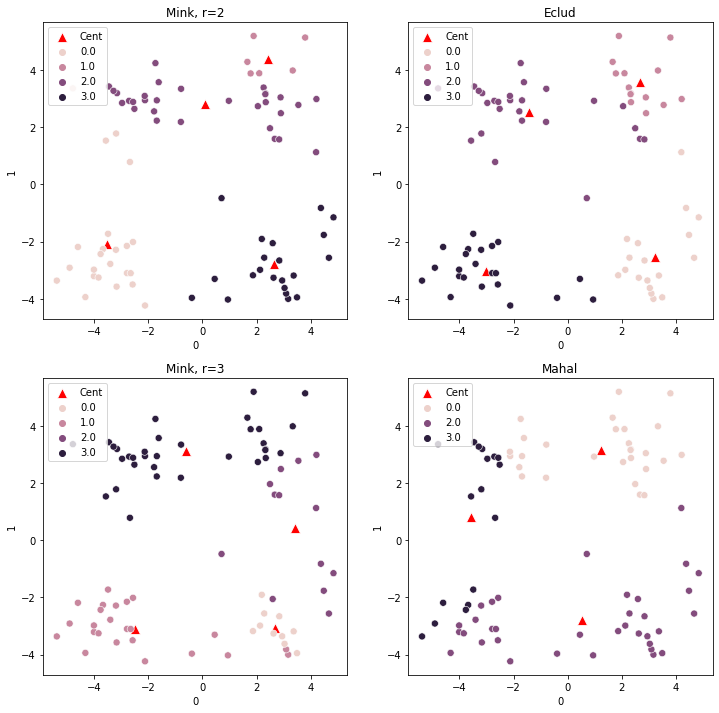

In [9]:
if __name__ =='__main__':
    """
    按照Kmeans原理来调用上述函数
    """
    fileName = './work/KmeansData.txt'
    dataMat = loadDataSet(fileName)
    k = 4
    
    fig = plt.figure(figsize=[12,12])
    ax1 = fig.add_subplot(221)
    centList,clusterAssment = kMeans(dataMat, k, distMeas=distMink, r=2, createCent=randCent)
    drawDataSet(dataMat, centList,clusterAssment, k, ax=ax1)
    ax1.set(title='Mink, r=2')
    ax2 = fig.add_subplot(222)
    centList,clusterAssment = kMeans(dataMat, k, distMeas=distEclud,createCent=randCent)
    drawDataSet(dataMat, centList,clusterAssment, k, ax=ax2)
    ax2.set(title='Eclud')
    ax3 = fig.add_subplot(223)
    centList,clusterAssment = kMeans(dataMat, k, distMeas=distMink, r=3, createCent=randCent)
    drawDataSet(dataMat, centList,clusterAssment, k, ax=ax3)
    ax3.set(title='Mink, r=3')
    ax4 = fig.add_subplot(224)
    centList,clusterAssment = kMeans(dataMat, k, distMeas=distMahal, Mat=np.array(dataMat).T, createCent=randCent)
    drawDataSet(dataMat, centList,clusterAssment, k, ax=ax4)
    ax4.set(title='Mahal')

## 7. 基于sklearn验证

In [10]:
from sklearn.cluster import KMeans
import seaborn as sns

In [11]:
SSE = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(dataMat)
    SSE.append(kmeans.inertia_)

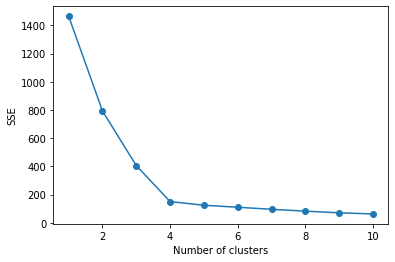

In [12]:
# 绘制k值与SSE的关系图
plt.plot(range(1, 11), SSE, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

> 当簇的个数增加时，SSE会急剧减小；
> 
> 而当簇的个数过大时，SSE的减小就会变得越来越缓慢，形成一个肘状的曲线；
>
> 因此，可以选择肘部处的簇的个数作为最优的K值，即K=4

In [13]:
# 聚类
kmeans = KMeans(n_clusters=4)
kmeans.fit(dataMat)
y_pred = kmeans.predict(dataMat)

In [14]:
df = pd.DataFrame(dataMat, columns=['x', 'y'])
df['y_pred'] = y_pred

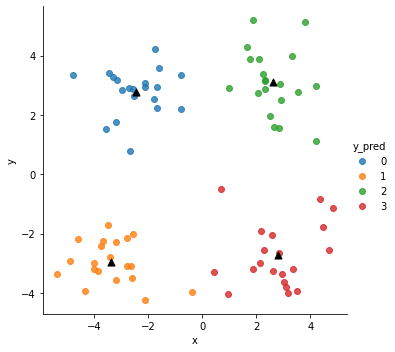

In [15]:
# 绘制图像
sns.lmplot(x='x', y='y', data=df, hue='y_pred', fit_reg=False)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=50, c='black', marker='^')
plt.show()